In [1]:
import airfrans as af
import matplotlib.pyplot as plt
from typing import Dict, Any

In [2]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

# 1. EDA

In [3]:
# to add to the dataset
# rescale the coordinates with a min-max
# 

In [4]:
import numpy as np
from sklearn.cluster import DBSCAN, AgglomerativeClustering,  BisectingKMeans, OPTICS

In [5]:
import torch

In [6]:
from collections import OrderedDict
from functools import partial

import einops
import coral.losses as losses
import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from torch import autograd
from torch.nn.parallel import DistributedDataParallel as DDP


def inner_loop(
    func_rep,
    modulations,
    graph,
    features,
    batch_index,
    n_samples,
    inner_steps,
    inner_lr,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
):
    """Performs inner loop, i.e. fits modulations such that the function
    representation can match the target features.

    Args:
        func_rep (models.ModulatedSiren):
        modulations (torch.Tensor): Shape (batch_size, latent_dim).
        coordinates (torch.Tensor): Coordinates at which function representation
            should be evaluated. Shape (batch_size, *, coordinate_dim).
        features (torch.Tensor): Target features for model to match. Shape
            (batch_size, *, feature_dim).
        inner_steps (int): Number of inner loop steps to take.
        inner_lr (float): Learning rate for inner loop.
        is_train (bool):
        gradient_checkpointing (bool): If True uses gradient checkpointing. This
            can massively reduce memory consumption.
    """
    fitted_modulations = modulations
    for step in range(inner_steps):
        if gradient_checkpointing:
            fitted_modulations = cp.checkpoint(
                inner_loop_step,
                func_rep,
                fitted_modulations,
                graph,
                features,
                torch.as_tensor(inner_lr),
                torch.as_tensor(is_train),
                torch.as_tensor(gradient_checkpointing),
                loss_type,
            )
        else:
            fitted_modulations = inner_loop_step(
                func_rep,
                fitted_modulations,
                graph,
                features,
                n_samples,
                inner_lr,
                is_train,
                gradient_checkpointing,
                loss_type,
            )
    return fitted_modulations


def inner_loop_step(
    func_rep,
    modulations,
    graph,
    features,
    n_samples,
    inner_lr,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
):
    """Performs a single inner loop step."""
    detach = not torch.is_grad_enabled() and gradient_checkpointing

    if loss_type == "mse":
        element_loss_fn = losses.per_element_mse_fn
    elif loss_type == "bce":
        element_loss_fn = losses.per_element_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        element_loss_fn = partial(
            losses.per_element_multi_scale_fn,
            loss_name=loss_name,
            last_element=False,
        )

    with torch.enable_grad():
        # Note we multiply by batch size here to undo the averaging across batch
        # elements from the MSE function. Indeed, each set of modulations is fit
        # independently and the size of the gradient should not depend on how
        # many elements are in the batch
        features_recon = func_rep.modulated_forward(graph, modulations)
        loss = element_loss_fn(features_recon, features).mean() * n_samples

        # If we are training, we should create graph since we will need this to
        # compute second order gradients in the MAML outer loop
        grad = torch.autograd.grad(
            loss,
            modulations.features,
            create_graph=is_train and not detach,
        )[0]
        # if clip_grad_value is not None:
        #    nn.utils.clip_grad_value_(grad, clip_grad_value)
    # Perform single gradient descent step
    modulations.features = modulations.features - inner_lr * grad
    return modulations


def outer_step(
    func_rep,
    graph,
    modulations,
    inner_steps,
    inner_lr,
    is_train=False,
    return_reconstructions=False,
    gradient_checkpointing=False,
    loss_type="mse",
    use_rel_loss=False,
):
    """

    Args:
        coordinates (torch.Tensor): Shape (batch_size, *, coordinate_dim). Note this
            _must_ have a batch dimension.
        features (torch.Tensor): Shape (batch_size, *, feature_dim). Note this _must_
            have a batch dimension.
    """

    if loss_type == "mse":
        loss_fn = torch.nn.MSELoss()
    elif loss_type == "bce":
        loss_fn = torch.nn.BCEWithLogitsLoss()
    func_rep.zero_grad()
    if isinstance(func_rep, DDP):
        func_rep = func_rep.module

    modulations.features = modulations.features.requires_grad_()
    n_samples = len(graph)
    batch_index = graph.batch
    features = graph.images.clone()

    # Run inner loop
    modulations = inner_loop(
        func_rep,
        modulations,
        graph,
        graph.images,
        batch_index,
        n_samples,
        inner_steps,
        inner_lr,
        is_train,
        gradient_checkpointing,
        loss_type,
    )

    with torch.set_grad_enabled(is_train):
        features_recon = func_rep.modulated_forward(graph, modulations)
        per_example_loss = loss_fn(features_recon, features)  # features
        loss = per_example_loss.mean()

    outputs = {
        "loss": loss,
        "psnr": losses.mse2psnr(per_example_loss).mean().item(),
        "modulations": modulations,
    }

    if return_reconstructions:
        outputs["reconstructions"] = (
            features_recon[-1] if "multiscale" in loss_type else features_recon
        )

    if use_rel_loss:
        rel_loss = (
            losses.batch_mse_rel_fn(features_recon[-1], features).mean()
            if "multiscale" in loss_type
            else losses.batch_mse_rel_fn(features_recon, features).mean()
        )
        outputs["rel_loss"] = rel_loss

    return outputs


# 2. Try to fit a single image for each channel

In [8]:
import os
import sys
from pathlib import Path
sys.path.append("/home/serrano/Projects/INR_domain_decomposition/")

from src.data.dataset import GeometryDataset, KEY_TO_INDEX
from torch_geometric.loader import DataLoader

import einops
import json
import hydra
import numpy as np
import torch
import torch.nn as nn
import wandb
from coral.mlp import MLP, Derivative, ResNet
from omegaconf import DictConfig, OmegaConf
from torchdiffeq import odeint

from coral.losses import batch_mse_rel_fn
from coral.siren import ModulatedSiren
from coral.utils.data import (
    shape2coordinates,
    DatasetWithCode,
    set_seed,
)
from coral.utils.plot import show
from coral.utils.scheduler import learning_rate_scheduler

In [9]:
import yaml
from omegaconf import DictConfig
from wisp.core import WispModule
from coral.siren import ModulatedSiren, LatentToModulation
from src.models.basic_conditioning import film, film_linear, film_translate


In [10]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)

In [11]:
data_dir = cfg.data.dir
task = cfg.data.task
data_to_encode = cfg.data.data_to_encode
score = cfg.data.score
ntrain = cfg.data.ntrain
ntest = cfg.data.ntest
seed = cfg.data.seed

In [13]:
NUM_NODES=64
LATENT_DIM=32

In [14]:
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from src.data.dataset import get_dataset
from sklearn.cluster import KMeans

class GeometryDataset2(Dataset):
    def __init__(self, set, key=None, latent_dim=256, scale_factor=1.0, norm=False, coef_norm=None, crop=None, sample="mesh", n_boot=8000, surf_ratio=.1):
        dataset, coef_norm = get_dataset(set, norm=norm, coef_norm=coef_norm, crop=crop, sample=None, n_boot=n_boot, surf_ratio=surf_ratio)
        self.dataset = dataset
        self.coef_norm = coef_norm
        print('coef_norm', coef_norm)
        self.modulations = torch.zeros(len(self.dataset), latent_dim)
        self.key = key
        self.scale_factor = scale_factor
        if key is not None:
            self.index = KEY_TO_INDEX[key]
            self.input_key = self.index <= 6
            self.relative_index = self.index if self.index <= 6 else self.index - 7
        self.sample = sample 
        self.n_points = n_boot
        self.set_modulation_pos()
    
    def set_modulation_pos(self):
        self.modulation_pos = torch.zeros(len(self.dataset), NUM_NODES, 2)
        for i in range(len(self.dataset)):
            clustering = BisectingKMeans(n_clusters=NUM_NODES, max_iter=1000)
            clustering.fit(self.dataset[i].pos)
            self.modulation_pos[i] = torch.from_numpy(clustering.cluster_centers_)
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        if self.sample == 'mesh':
            mask = torch.randperm(self.dataset[i].pos.shape[0])[:self.n_points]
            if self.key == None:
                return (self.dataset[i], i)

            else:   
                scaled_pos = (self.dataset[i].pos[mask] - MIN_POS) / (MAX_POS - MIN_POS) * self.scale_factor
                graph = Data(pos=scaled_pos, edge_index=None)
                graph.surface = self.dataset[i].surf[mask]
                graph.sdf = self.dataset[i].x[mask, KEY_TO_INDEX['sdf']].unsqueeze(-1)
                modulations = Data(pos=(self.modulation_pos[i] - MIN_POS) / (MAX_POS - MIN_POS) * self.scale_factor,
                                   features=torch.zeros(NUM_NODES, LATENT_DIM))
                
                if self.input_key:
                    graph.images = self.dataset[i].x[mask, self.relative_index].unsqueeze(-1)
                else:
                    graph.images = self.dataset[i].y[mask, self.relative_index].unsqueeze(-1)

                return (graph, modulations, i)
        else:
            if self.key == None:
                return (self.dataset[i], i)

            else:   
                scaled_pos = (self.dataset[i].pos - MIN_POS) / (MAX_POS - MIN_POS) * self.scale_factor
                graph = Data(pos=scaled_pos, edge_index=None)
                graph.surface = self.dataset[i].surf
                graph.sdf = self.dataset[i].x[..., KEY_TO_INDEX['sdf']].unsqueeze(-1)
                modulations = Data(pos=torch.rand(NUM_NODES, 2), features=torch.randn(NUM_NODES, LATENT_DIM))
                
                if self.input_key:
                    graph.images = self.dataset[i].x[..., self.relative_index].unsqueeze(-1)
                else:
                    graph.images = self.dataset[i].y[..., self.relative_index].unsqueeze(-1)

                return (graph, modulations, i)

In [16]:
data_to_encode = 'p'

In [17]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:32] # was [:-n] ???
valset = manifest_train[-32:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [18]:
#default sample is none
latent_dim = 128
batch_size = 32
trainset = GeometryDataset2(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample="mesh", n_boot=4000)
print("loaded train")
valset = GeometryDataset2(valset, key=data_to_encode, latent_dim=latent_dim, sample="mesh",n_boot=4000, coef_norm=trainset.coef_norm)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:12<00:00,  2.57it/s]


coef_norm (array([ 4.99155134e-01,  1.04347775e-02,  6.22724419e+01,  3.57993126e+00,
        2.31595457e-01, -1.73257047e-03, -8.89778676e-05], dtype=float32), array([ 0.70521986,  0.33678687, 17.276781  ,  5.563543  ,  0.47490114,
        0.04318496,  0.06127373], dtype=float32), array([ 4.2443611e+01,  6.6022849e+00, -1.2313610e+02,  7.5809297e-04],
      dtype=float32), array([2.8258753e+01, 2.4545864e+01, 1.6239836e+03, 2.4214562e-03],
      dtype=float32))
loaded train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.62it/s]


coef_norm (array([ 4.99155134e-01,  1.04347775e-02,  6.22724419e+01,  3.57993126e+00,
        2.31595457e-01, -1.73257047e-03, -8.89778676e-05], dtype=float32), array([ 0.70521986,  0.33678687, 17.276781  ,  5.563543  ,  0.47490114,
        0.04318496,  0.06127373], dtype=float32), array([ 4.2443611e+01,  6.6022849e+00, -1.2313610e+02,  7.5809297e-04],
      dtype=float32), array([2.8258753e+01, 2.4545864e+01, 1.6239836e+03, 2.4214562e-03],
      dtype=float32))


In [19]:
class PositionalEmbedder2(WispModule):
    """PyTorch implementation of regular positional embedding, as used in the original NeRF and Transformer papers.
    """
    def __init__(self, num_freq, max_freq_log2, log_sampling=True, include_input=True, input_dim=3, base_freq=2):
        """Initialize the module.
        Args:
            num_freq (int): The number of frequency bands to sample. 
            max_freq_log2 (int): The maximum frequency.
                                 The bands will be sampled at regular intervals in [0, 2^max_freq_log2].
            log_sampling (bool): If true, will sample frequency bands in log space.
            include_input (bool): If true, will concatenate the input.
            input_dim (int): The dimension of the input coordinate space.
        Returns:
            (void): Initializes the encoding.
        """
        super().__init__()

        self.num_freq = num_freq
        self.max_freq_log2 = max_freq_log2
        self.log_sampling = log_sampling
        self.include_input = include_input
        self.out_dim = 0
        self.base_freq = base_freq

        if include_input:
            self.out_dim += input_dim

        if self.log_sampling:
            self.bands = self.base_freq**torch.linspace(0.0, max_freq_log2, steps=num_freq)
        else:
            self.bands = torch.linspace(1, self.base_freq**max_freq_log2, steps=num_freq)

        # The out_dim is really just input_dim + num_freq * input_dim * 2 (for sin and cos)
        self.out_dim += self.bands.shape[0] * input_dim * 2
        self.bands = nn.Parameter(self.bands).requires_grad_(False)
    
    def forward(self, coords):
        """Embeds the coordinates.
        Args:
            coords (torch.FloatTensor): Coordinates of shape [N, input_dim]
        Returns:
            (torch.FloatTensor): Embeddings of shape [N, input_dim + out_dim] or [N, out_dim].
        """
        N = coords.shape[0]
        winded = (coords[:,None] * self.bands[None,:,None]).reshape(
            N, coords.shape[1] * self.num_freq)
        encoded = torch.cat([torch.sin(winded), torch.cos(winded)], dim=-1)
        if self.include_input:
            encoded = torch.cat([coords, encoded], dim=-1)
        return encoded

    def name(self) -> str:
        """ A human readable name for the given wisp module. """
        return "Positional Encoding"

    def public_properties(self) -> Dict[str, Any]:
        """ Wisp modules expose their public properties in a dictionary.
        The purpose of this method is to give an easy table of outwards facing attributes,
        for the purpose of logging, gui apps, etc.
        """
        return {
            "Output Dim": self.out_dim,
            "Num. Frequencies": self.num_freq,
            "Max Frequency": f"2^{self.max_freq_log2}",
            "Include Input": self.include_input
        }

In [143]:
from torch_geometric.nn.conv import SAGEConv, GCNConv, GATConv
from torch_geometric.nn import radius_graph, knn_graph
from torch_geometric.nn.unpool import knn_interpolate
from torch_geometric.utils import to_undirected
from torch_geometric.nn.pool import max_pool, global_max_pool


class ModulatedPositionalEmbedder(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, num_frequencies=8, latent_dim=128,  width=256, depth=3, modulate_scale=False, modulate_shift=True):
        super().__init__()
        self.embedding = PositionalEmbedder2(num_frequencies, 8, log_sampling=True, include_input=False, input_dim=input_dim, base_freq=2)
        #self.network = tcnn.Network(self.encoding.n_output_dims, output_dim, config["network"])
        self.input_dim=input_dim
        self.latent_dim = latent_dim
        self.in_channels = [self.embedding.out_dim] + [width]*(depth-1)
        self.out_channels = [width]*(depth-1) + [output_dim]
        self.layers = nn.ModuleList([nn.Linear(self.in_channels[k], self.out_channels[k]) for k in range(depth)])
        self.depth=depth
        self.hidden_dim = width

        self.num_modulations = self.hidden_dim * (self.depth-1)
        if modulate_scale and modulate_shift:
            # If we modulate both scale and shift, we have twice the number of
            # modulations at every layer and feature
            self.num_modulations *= 2
        #self.latent_to_modulation = LatentToModulation(8, self.num_modulations, dim_hidden=256, num_layers=1)
        self.mp1 = SAGEConv(in_channels=LATENT_DIM, out_channels=self.num_modulations, project=False)
        #self.mp2 = SAGEConv(in_channels=64, out_channels=256, project=False)
        #self.mp1 = GATConv(in_channels=LATENT_DIM, out_channels=self.num_modulations) 
        
        self.local_to_modulation = nn.Linear(64, self.num_modulations)
        self.global_to_modulation = nn.Linear(256, self.num_modulations)
        #self.latent_to_modulation = GCNConv(in_channels=LATENT_DIM, out_channels=self.num_modulations)

        if modulate_shift and modulate_scale:
            self.conditioning = film
        elif modulate_scale and not modulate_shift: 
            self.conditioning = film_linear
        else:
            self.conditioning = film_translate

    def modulated_forward(self, graph, z):
        #z.edge_index = radius_graph(z.pos,
        #    1,
        #    z.batch,
        #    loop=False,
        #    max_num_neighbors=5,
        #)
        edge_index = knn_graph(
            z.pos,
            k=8,
            batch=z.batch,
            loop=False,
            flow='source_to_target',
            cosine=False,
            num_workers=1,
        )
        #relative_mesh_pos = z.pos[edge_index[0]] - z.pos[edge_index[1]]
        #edge_features = torch.cat([relative_mesh_pos, torch.linalg.norm(relative_mesh_pos, axis=-1, keepdims=True)], axis=-1)
        #edge_index = to_undirected(edge_index, num_nodes=z.num_nodes)
        z.edge_index = edge_index
        local_features = self.mp1(z.features, z.edge_index)#, edge_features)
        #global_features = self.mp2(torch.relu(local_features), z.edge_index)
        #global_features = global_max_pool(global_features, z.batch)
        
        features_interpolate = knn_interpolate(local_features, z.pos, graph.pos, z.batch, graph.batch, k=3)
        #modulations = self.local_to_modulation(features_interpolate) + self.global_to_modulation(global_features[graph.batch])
        
        if self.input_dim == 3:
            inpt = torch.cat([graph.pos, graph.sdf], axis=-1)
        else:
            inpt = graph.pos
            
        position = self.embedding(inpt)
        pre_out = self.conditioning(position, features_interpolate, self.layers[:-1], torch.relu)
        out = self.layers[-1](pre_out)
        return out

In [144]:
edge_index = knn_graph(
            modulations.pos,
            k=8,
            batch=modulations.batch,
            loop=False,
            flow='source_to_target',
            cosine=False,
            num_workers=1,
        )

In [145]:
edge_index[..., 0]

tensor([5, 0], device='cuda:0')

In [111]:
relative_mesh_pos = modulations.pos[edge_index[0]] - modulations.pos[edge_index[1]]
edge_features = torch.cat([
        relative_mesh_pos,
        torch.linalg.norm(relative_mesh_pos, axis=-1, keepdims=True)], axis=-1)

In [112]:
modulations.pos.shape

torch.Size([2048, 2])

In [113]:
relative_mesh_pos.shape

torch.Size([16384, 2])

In [104]:
edge_features.shape

torch.Size([2, 3])

In [ ]:
torch.linalg.norm(

In [80]:
MIN_POS = 0
MAX_POS = 1

In [166]:
model = ModulatedPositionalEmbedder(num_frequencies=32, input_dim=3).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [82]:
# check how to generate the grid
# implement metalearning with this to check

In [167]:
for graph, modulations, idx in train_loader:
    break

In [83]:
modulations = modulations.cuda()
graph = graph.cuda()

In [ ]:
for step in range(2000):
    for graph, modulations, idx in train_loader:
        modulations = modulations.cuda()
        graph = graph.cuda()
        
        outputs = outer_step(
        model,
        graph,
        modulations,
        3,
        0.1,
        is_train=True,
        return_reconstructions=False,
        gradient_checkpointing=False,
        loss_type="mse",
        use_rel_loss=False,
        )
        optimizer.zero_grad()
        outputs['loss'].backward(create_graph=False)
        optimizer.step()

        loss = outputs['loss'].item()
        if step%20==0:
            print(step, loss)

0 1.0133832693099976
20 0.4290400445461273
40 0.15595556795597076
60 0.09223436564207077
80 0.02891291119158268
100 0.015701230615377426
120 0.011432493105530739
140 0.009104370139539242
160 0.007525554858148098
180 0.006424466148018837
200 0.005392438732087612
220 0.005542331840842962
240 0.00443106098100543
260 0.004065534565597773
280 0.004097180441021919
300 0.003446996444836259
320 0.0033717118203639984
340 0.0030896062962710857
360 0.00281089311465621
380 0.0030072415247559547
400 0.0026717609725892544
420 0.0024223062209784985
440 0.002597997896373272
460 0.0022573138121515512
480 0.002088695066049695
500 0.002338023390620947
520 0.0019300649873912334
540 0.0017759217880666256
560 0.002019337611272931
580 0.0016681546112522483
600 0.0017965261358767748
620 0.001548440777696669
640 0.0016547120176255703
660 0.0014068485470488667
680 0.0014291475526988506
700 0.0013945386745035648
720 0.0013842566404491663
740 0.0012552771950140595
760 0.0012432511430233717
780 0.00125371746253222

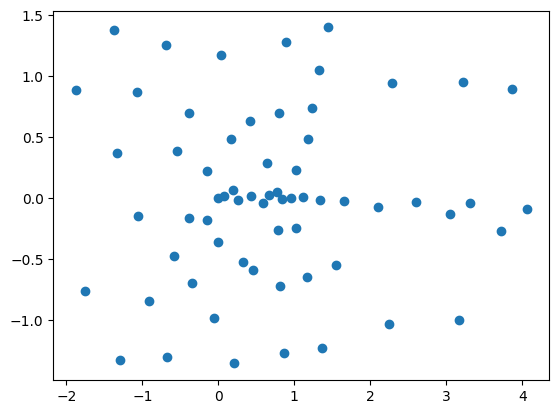

In [148]:
index=0
tt = modulations.pos[modulations.batch==index].cpu().detach()
plt.scatter(tt[..., 0], tt[..., 1])

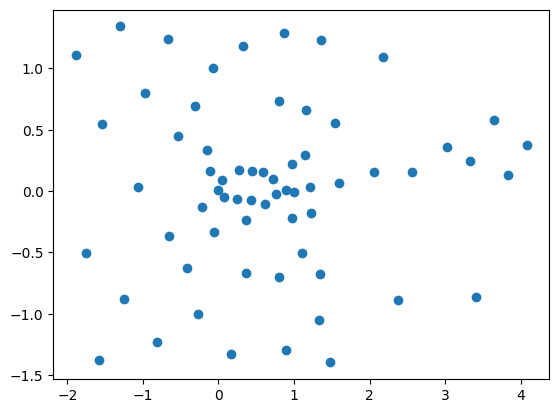

In [149]:
index=1
tt = modulations.pos[modulations.batch==index].cpu().detach()
plt.scatter(tt[..., 0], tt[..., 1])

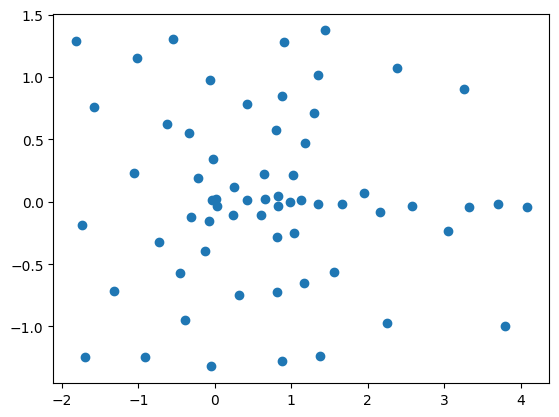

In [150]:
index=2
tt = modulations.pos[modulations.batch==index].cpu().detach()
plt.scatter(tt[..., 0], tt[..., 1])

In [151]:
with torch.no_grad():
    pred = model.modulated_forward(graph, modulations)

In [152]:
idx

tensor([14,  9,  8, 19,  2, 31, 17, 21, 30,  7, 29, 22, 24,  4, 11, 13, 28,  5,
         0, 27, 10,  1, 25, 20, 15, 26, 12, 23,  3,  6, 18, 16])

In [159]:
index = 0
mask = graph.batch == index

In [160]:
from torch_geometric.data.batch import DataBatch

In [161]:
sample = DataBatch(pos = (trainset.dataset[idx[index]].pos - MIN_POS) / (MAX_POS - MIN_POS))
sample.sdf = trainset.dataset[idx[index]].x[..., 4].unsqueeze(-1)
sample.batch = torch.ones(sample.pos.shape[0]).long()*index
sample.images = trainset.dataset[idx[index]].y[..., trainset.relative_index].unsqueeze(-1)

In [162]:
pred = model.modulated_forward(sample.cuda(),modulations)

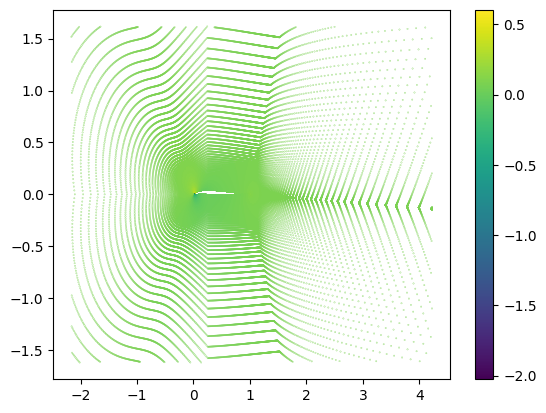

In [163]:
plt.scatter(sample.pos[..., 0].cpu().detach(), sample.pos[..., 1].cpu().detach(), c=sample.images.cpu().detach().squeeze(), s=0.05)
plt.colorbar()

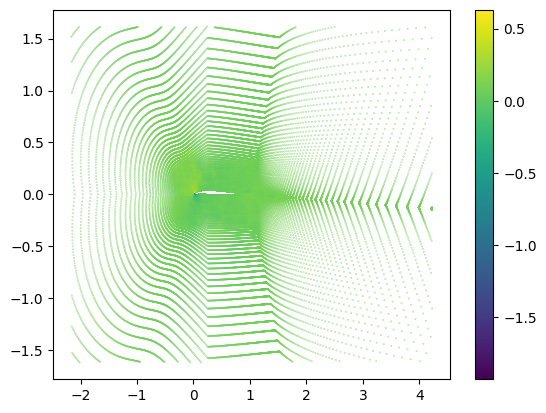

In [164]:
plt.scatter(sample.pos[..., 0].cpu().detach(), sample.pos[..., 1].cpu().detach(), c=pred.cpu().detach().squeeze(), s=0.05)
plt.colorbar()

In [165]:
graph

DataBatch(pos=[128000, 2], surface=[128000], sdf=[128000, 1], images=[128000, 1], batch=[128000], ptr=[33])

In [417]:
from torch_geometric.data.batch import DataBatch

In [420]:
sample = DataBatch(pos = (trainset.dataset[idx[index]].pos - MIN_POS) / (MAX_POS - MIN_POS) * trainset.scale_factor)
sample.sdf = trainset.dataset[idx[index]].x[..., 4].unsqueeze(-1)
sample.batch = torch.zeros(sample.pos.shape[0]).long()
sample.images = trainset.dataset[idx[index]].y[..., trainset.relative_index].unsqueeze(-1)

modulations = DataBatch(pos=(trainset.modulation_pos[idx[index]] - MIN_POS) / (MAX_POS - MIN_POS) * trainset.scale_factor,
                                   features=torch.zeros(NUM_NODES, LATENT_DIM))
modulations.batch = torch.zeros(modulations.pos.shape[0]).long()

outputs = outer_step(
        model,
        sample.cuda(),
        modulations.cuda(),
        3,
        0.01,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        loss_type="mse",
        use_rel_loss=False,
        )

In [421]:
outputs['modulations'].features

tensor([[-1.0683e-03, -9.9334e-04, -1.6891e-03,  ...,  2.7878e-04,
         -1.4218e-03,  2.3945e-04],
        [-1.8292e-03, -1.1498e-03, -3.1308e-03,  ...,  2.0959e-03,
          4.0493e-04,  1.4223e-04],
        [-8.0651e-04, -1.3922e-03, -1.4029e-03,  ...,  3.4870e-05,
         -2.8373e-04,  6.0611e-04],
        ...,
        [ 4.5425e-05,  1.4397e-04,  6.1039e-05,  ..., -1.5480e-04,
         -3.4468e-04, -7.7581e-06],
        [ 1.1842e-04,  1.6882e-04,  5.2274e-04,  ..., -4.9048e-04,
         -2.5990e-04, -1.4234e-04],
        [ 1.1029e-04,  7.1592e-05,  4.3704e-04,  ..., -6.1303e-04,
         -5.3433e-04, -5.2195e-05]], device='cuda:0', grad_fn=<SubBackward0>)

In [422]:
print('loss', outputs['loss'])

loss tensor(0.0024, device='cuda:0')


In [423]:
pred = outputs['reconstructions']

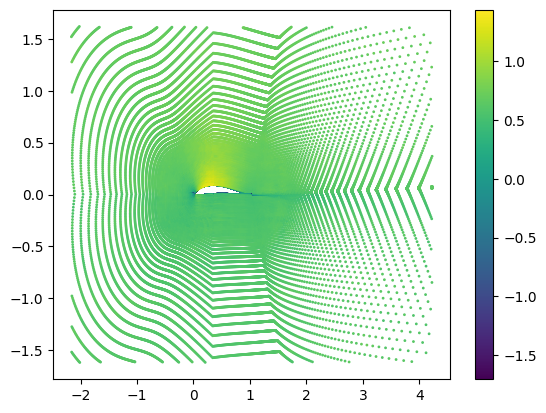

In [424]:
plt.scatter(sample.pos[..., 0].cpu().detach(), sample.pos[..., 1].cpu().detach(), c=pred.cpu().detach().squeeze(), s=1)
plt.colorbar()

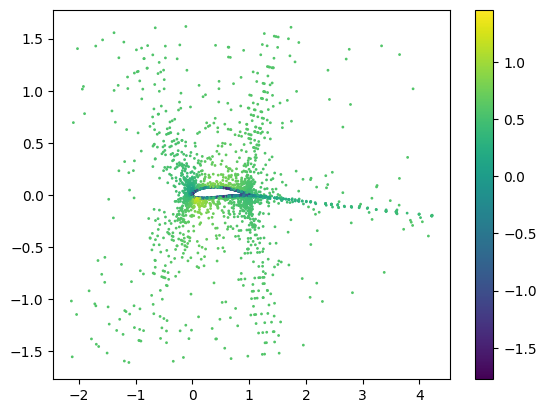

In [260]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach().squeeze(), s=1)
plt.colorbar()

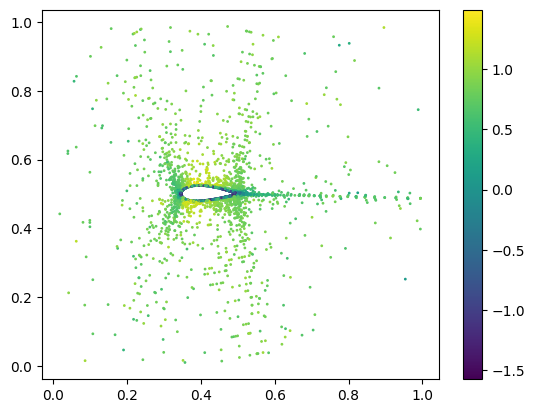

In [174]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=pred[mask].cpu().detach().squeeze(), s=1)
plt.colorbar()

In [38]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering,  BisectingKMeans, OPTICS

In [20]:
x = trainset.dataset[9].pos

In [22]:
from sklearn.cluster import KMeans

In [49]:
#clustering = KMeans(n_clusters=64, max_iter=1000)
#clustering = BisectingKMeans(n_clusters=128)
clustering = OPTICS(max_eps=0.2, min_samples=1500)

In [50]:
clustering.fit(x)

OPTICS(max_eps=0.2, min_samples=1500)

In [51]:
mod_pos = clustering.cluster_hierarchy_

In [52]:
mod_pos.shape

(1, 2)

In [ ]:
plt.scatter(modulation_pos[:, 0], modulation_pos[:, 1])

In [34]:
modulation_pos = clustering.cluster_centers_

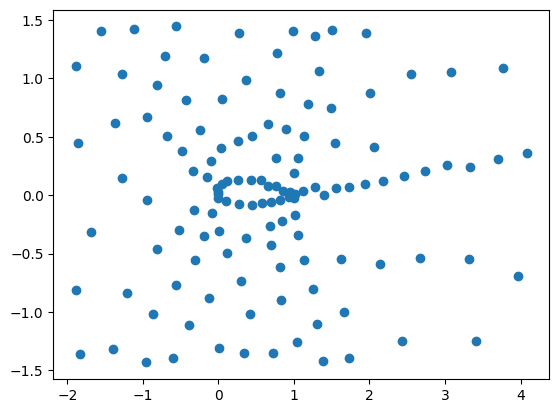

In [35]:
plt.scatter(modulation_pos[:, 0], modulation_pos[:, 1])

In [102]:
z = outputs['modulations']

In [105]:
tt = z.pos[z.batch==0].cpu().detach()

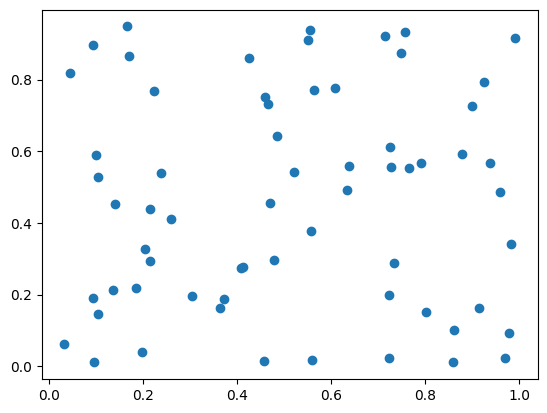

In [106]:
plt.scatter(tt[:, 0], tt[:, 1])

In [103]:
z.features[z.batch==0]

tensor([[-8.6326e-06,  1.6590e-06,  1.8854e-06, -5.1452e-06,  2.7385e-06,
         -4.7858e-06, -2.1872e-06,  3.1450e-06],
        [-1.8727e-05,  1.2922e-05,  1.2773e-05, -1.0537e-05,  2.5579e-06,
         -1.0099e-05, -1.3112e-05,  1.2039e-05],
        [-3.4680e-06,  1.0654e-06,  1.4620e-06, -2.6526e-06,  7.3540e-07,
         -2.8994e-06, -1.6101e-06,  1.4812e-06],
        [-5.3078e-07,  5.3349e-08,  5.3472e-07, -6.6806e-07,  2.4902e-08,
         -1.5645e-07, -4.6070e-07,  7.0673e-07],
        [ 1.1717e-05, -2.7817e-06, -2.4528e-06,  5.5059e-06, -3.8720e-06,
          4.4045e-06,  8.9890e-06, -3.6515e-06],
        [ 7.3099e-06, -1.0252e-06,  1.5076e-06,  4.9575e-06, -7.8885e-07,
          3.0641e-06,  7.2440e-06, -1.6226e-06],
        [-1.3073e-06,  2.1978e-08,  1.0671e-06, -1.1928e-06, -3.3835e-08,
         -3.8270e-07, -7.4704e-07,  1.3013e-06],
        [ 2.0488e-05, -1.0762e-05, -3.7669e-06,  1.3581e-05, -7.8281e-06,
          5.9218e-06,  1.5980e-05, -1.2367e-05],
        [-1.3166

In [18]:
epochs=5000
#cfg.encoding.n_levels = 4
#cfg.encoding.n_features_per_level = 4
#cfg.encoding.base_resolution = 16
#cfg.encoding.per_level_scale = 2

cfg.network.activation = "ReLU"
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)

cfg_dict = OmegaConf.to_container(cfg)
input_dim = 2
output_dim = 1

# Option 1: efficient Encoding+Network combo.
nef = tcnn.NetworkWithInputEncoding(
    input_dim, output_dim,
    cfg_dict["encoding"], cfg_dict["network"]
).cuda()

optimizer = torch.optim.Adam(nef.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

In [145]:
for graph, idx in train_loader:
    break

In [146]:
index = 0
mask = graph.batch == index

In [147]:
gamma = 1
coordinates = graph.pos[mask].cuda()
images = graph.images[mask].cuda()
images_scaled = images/gamma # images/ gamma

In [148]:
for step in range(epochs):
    mask = torch.randperm(coordinates.shape[0])[:18000]
    pred = nef(coordinates[mask])
    loss = ((pred - images_scaled[mask])**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % 1000 == 0:
        print(f"loss: {((pred*gamma - images[mask])**2).mean()}")

loss: 0.8120287656784058
loss: 0.010440965183079243
loss: 0.005697167478501797
loss: 0.00387486070394516
loss: 0.0035044681280851364


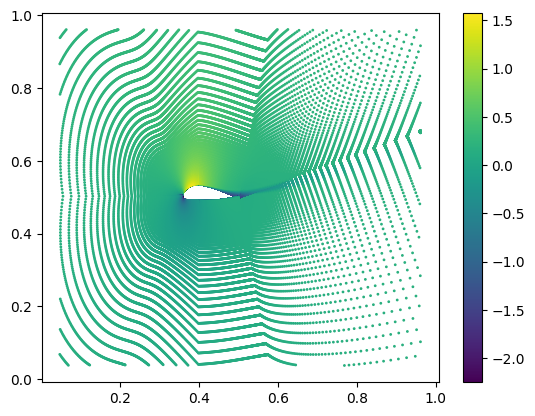

In [149]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=images.cpu().detach(), s=1)
plt.colorbar()

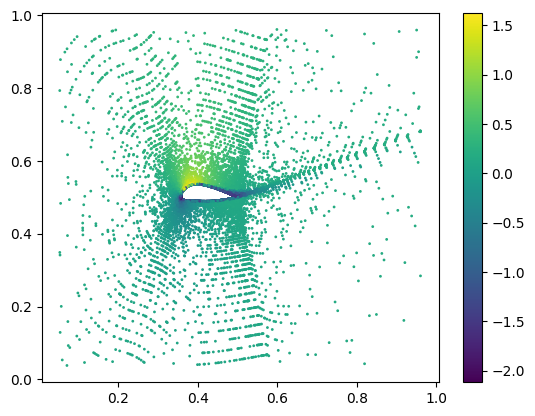

In [150]:
plt.scatter(coordinates[mask, 0].detach().cpu(), coordinates[mask, 1].detach().cpu(), c=gamma*pred.cpu().detach(), s=1)
plt.colorbar()

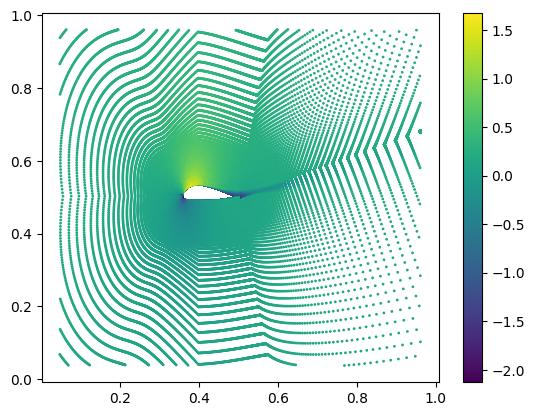

In [152]:
pred2 = nef(coordinates)
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=gamma*pred2.cpu().detach(), s=1)
plt.colorbar()

In [153]:
((pred2 - images)**2).mean()

tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)

In [32]:
loss

tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)

# Try auto-decoding

In [154]:
cfg_dict['encoding']

{'otype': 'Grid',
 'type': 'Dense',
 'n_levels': 6,
 'n_features_per_level': 2,
 'log2_hashmap_size': 6,
 'base_resolution': 8,
 'per_level_scale': 1.5}

In [155]:
class ModulatedDecoder(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        self.encoding = tcnn.Encoding(input_dim, config["encoding"], dtype=torch.float)
        self.frequency = tcnn.Encoding(input_dim, {"otype": "Frequency", "n_frequencies": 4 }, dtype=torch.float)
        self.network = tcnn.Network(self.encoding.n_output_dims + self.frequency.n_output_dims, 32, config["network"])

    def forward(self, x, instance_decoder):
        position = torch.cat([self.encoding(x), self.frequency(x)], axis=-1)
        out = self.network(position)
        out = instance_decoder(out)
        return out


In [208]:
class ModulatedTinyCuda(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        self.encoding = tcnn.Encoding(input_dim, config["encoding"], dtype=torch.float)
        self.frequency = tcnn.Encoding(input_dim, {"otype": "Frequency", "n_frequencies": 8}, dtype=torch.float)
        mlp_config = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "ReLU", "n_neurons": 64, "n_hidden_layers": 0}
        
        mlp_config_out = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "None", "n_neurons": 64, "n_hidden_layers": 0}
        
        self.network1 = tcnn.Network(self.encoding.n_output_dims, 64, mlp_config)
        self.network2 = tcnn.Network(64, 64, mlp_config)
        self.network3 = tcnn.Network(64, 64, mlp_config)
        self.network4 = tcnn.Network(64, 64, mlp_config)
        self.network5 = tcnn.Network(64, 64, mlp_config)
        self.network6 = tcnn.Network(64, output_dim, mlp_config_out)
        
        self.bias1 = nn.Parameter(torch.zeros(64))
        self.bias2 = nn.Parameter(torch.zeros(64))
        self.bias3 = nn.Parameter(torch.zeros(64))
        self.bias4 = nn.Parameter(torch.zeros(64))
        self.bias5 = nn.Parameter(torch.zeros(64))
        self.bias6 = nn.Parameter(torch.zeros(1))
        
        self.latent_to_modulation = tcnn.Network(8, 5*64, config["network"])
        

    def forward(self, x, instance_encoder):
        modulations = self.latent_to_modulation(instance_encoder(x)).reshape(-1, 64, 5)
        #position = self.frequency(x)
        position = self.encoding(x)
        #x = (1 + modulations[..., 0, 0] ) * self.network1(position) + modulations[..., 0, 1]  
        #x = (1 + modulations[..., 1, 0] ) * self.network2(x) + modulations[..., 1, 1]
        #x = (1 + modulations[..., 2, 0] ) * self.network3(x) + modulations[..., 2, 1]
        x = self.network1(position) + modulations[..., 0] + self.bias1
        x = self.network2(x) + modulations[..., 1] + self.bias2
        x = self.network3(x) + modulations[..., 2] + self.bias3
        x = self.network4(x) + modulations[..., 3] + self.bias4
        x = self.network5(x) + modulations[..., 4] + self.bias5
        out = self.network6(x) + self.bias6
        return out


In [196]:
class ModulatedBigCuda(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        enc_dict = config["encoding"].copy()
        enc_dict['n_features_per_level'] = 2
        enc_dict['n_levels'] = 8
        enc_dict['log2_hashmap_size'] = 14
        self.encoding = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.network = tcnn.Network(self.encoding.n_output_dims, output_dim, config["network"])
        
        mlp_config = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "None", "n_neurons": self.encoding.n_output_dims, "n_hidden_layers": 0}
        
        self.latent_to_modulation = tcnn.Network(12, self.encoding.n_output_dims, mlp_config)
        #nn.Linear(8, self.encoding.n_output_dims)

    def forward(self, x, instance_encoder):
        position = self.encoding(x) + self.latent_to_modulation(instance_encoder(x))
        #position = instance_encoder(x)
        out = self.network(position)
        return out

In [197]:
class ModulatedBigBigCuda(nn.Module):
    def __init__(self, input_dim, output_dim, config, latent_dim=64, modulate_scale=False, modulate_shift=True):
        super().__init__()
        enc_dict = config["encoding"].copy()
        enc_dict['n_features_per_level'] = 8
        enc_dict['n_levels'] = 8
        enc_dict['log2_hashmap_size'] = 14
        self.encoding1 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.encoding2 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.encoding3 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        self.encoding4 = tcnn.Encoding(input_dim, enc_dict, dtype=torch.float)
        
        self.network = tcnn.Network(4*self.encoding1.n_output_dims, output_dim, config["network"])
        
        mlp_config = {"otype": "CutlassMLP",     
         "activation": "None",      
        "output_activation": "None", "n_neurons": self.encoding1.n_output_dims, "n_hidden_layers": 0}
        
        self.latent_to_modulation = tcnn.Network(12, 4*self.encoding1.n_output_dims, mlp_config)
        #nn.Linear(8, self.encoding.n_output_dims)

    def forward(self, x, instance_encoder):
        position = torch.cat([self.encoding1(x),
                              self.encoding2(x),
                              self.encoding3(x),
                              self.encoding4(x)], axis=-1)
        position = position + self.latent_to_modulation(instance_encoder(x))
        #position = instance_encoder(x)
        out = self.network(position)
        return out


In [162]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [163]:
tinymodel = ModulatedTinyCuda(2, 1, cfg_dict).cuda()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs // 5, gamma=0.5)

In [274]:
encoding_list = [tcnn.Encoding(2, cfg_dict["encoding"]).cuda() for k in range(ntrain)]

In [275]:
import itertools

In [276]:
code_optimizer = torch.optim.Adam(itertools.chain(*[enc.parameters() for enc in encoding_list]), lr=1e-3)

In [277]:
for step in range(10000):
    train_loss = 0
    for graph, idx in train_loader:
        coordinates = graph.pos.cuda()
        images = graph.images.cuda()
        code_optimizer.zero_grad()
        n_samples = len(graph)
        
        for sample in idx:
            crds = coordinates[graph.batch == sample]
            img = images[graph.batch == sample]
            mask = torch.randperm(crds.shape[0])[:18000]
            crds = crds[mask]
            img = img[mask]
        
            pred = tinymodel(crds, encoding_list[sample])
            loss = ((pred-img)**2).mean()
            loss.backward()
            train_loss += loss.item()                     
        code_optimizer.step()
                             
    optimizer.step()
    optimizer.zero_grad()
    
    if step%100==0:
        print('train_loss', train_loss / ntrain)
    
    scheduler.step()

train_loss 0.9952403903007507
train_loss 0.8923378586769104
train_loss 0.7858007252216339
train_loss 0.6818812191486359
train_loss 0.6290302574634552
train_loss 0.5903408527374268
train_loss 0.5612855702638626
train_loss 0.5600047260522842
train_loss 0.5442007035017014
train_loss 0.5239408612251282
train_loss 0.5544175803661346
train_loss 0.544961005449295
train_loss 0.5516579151153564
train_loss 0.5243181437253952
train_loss 0.5320151746273041
train_loss 0.5246268659830093
train_loss 0.5356601625680923
train_loss 0.5218006372451782
train_loss 0.5257488340139389
train_loss 0.5180391073226929
train_loss 0.5109315663576126
train_loss 0.5280763804912567
train_loss 0.5159168988466263
train_loss 0.5248792320489883
train_loss 0.525217741727829
train_loss 0.5171073079109192
train_loss 0.5323787182569504
train_loss 0.4957311153411865
train_loss 0.5086396932601929
train_loss 0.5229227393865585
train_loss 0.4952071011066437
train_loss 0.4894024580717087
train_loss 0.5275470167398453
train_loss 0

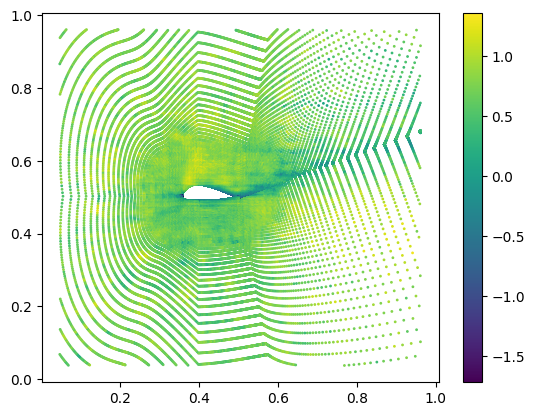

In [278]:
kk= 0
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)
plt.colorbar()

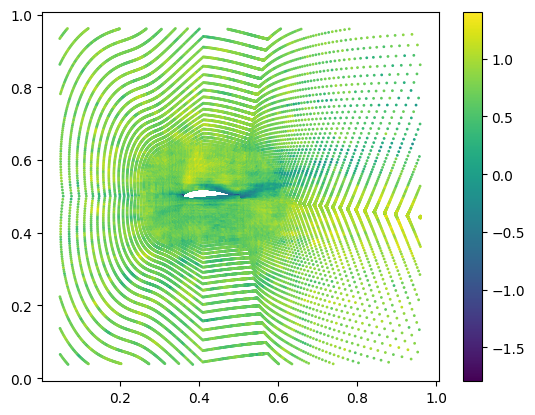

In [279]:
kk= 1
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)
plt.colorbar()

In [174]:
train_loss/ntrain

0.41150604337453844

In [133]:
code_optimizer.param_groups[0]['params'][0].dtype

torch.float32

In [134]:
pred.dtype

torch.float16

In [198]:
def zero_out_params(enc_list):
    for k in range(len(enc_list)):
        enc_list[k].params = nn.Parameter(torch.zeros_like(enc_list[k].params))
    return enc_list

In [200]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [228]:
cfg_example_grid = {
"otype": "Grid",
"type": "Dense", 
    "n_levels": 1,
    "n_features_per_level": 2,
    "log2_hashmap_size": 4,
    "base_resolution": 32,
    "per_level_scale": 1.5,
    "interpolation": "Linear"
}

In [229]:
tinymodel = ModulatedTinyCuda(2, 1, cfg_dict).cuda()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

In [230]:
next(iter(tinymodel.parameters())).dtype

torch.float32

In [231]:
encoding_list[0].params.shape

torch.Size([10096])

In [232]:
encoding_list = [tcnn.Encoding(2, cfg_example_grid).cuda() for k in range(ntrain)]

In [233]:
for step in range(1000):
    train_loss = 0
    for graph, idx in train_loader:
        n_samples = len(graph)
        
        outputs = outer_step(tinymodel,
                            graph.cuda(),
                            encoding_list,
                            3,
                            0.01,
                            is_train=True,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
        loss = outputs['loss']
        optimizer.zero_grad()
        loss.backward(create_graph=False)
        optimizer.step()
        train_loss = loss.item()*n_samples
    if step%100==0:
        print('train_loss', step, train_loss / ntrain)
    

RuntimeError: tinycudann/bindings.cpp:87 check failed input.size(1) == n_input_dims()

In [218]:
outputs = outer_step(tinymodel,
                            graph.cuda(),
                            encoding_list,
                            3,
                            0.01,
                            is_train=False,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
print('outputs', outputs['loss'])

outputs tensor(0.2325, device='cuda:0')


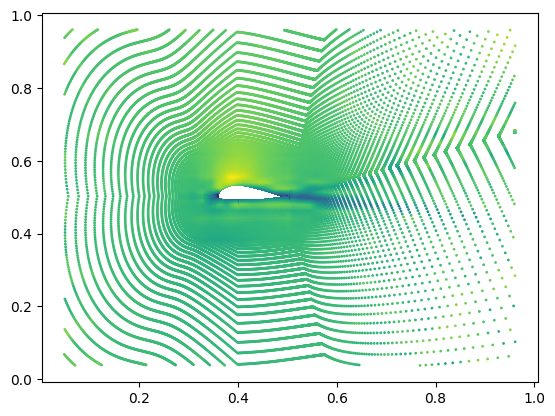

In [219]:
kk= 0
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

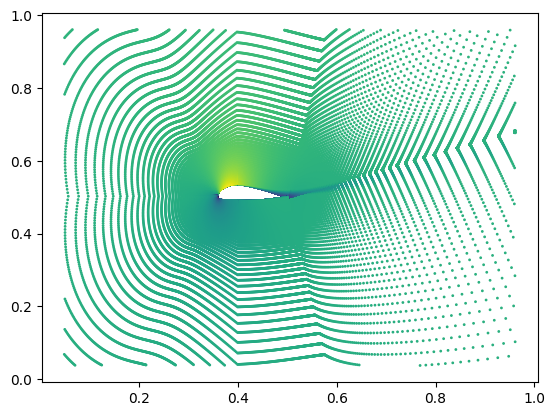

In [220]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=graph.images[graph.batch==kk].cpu().detach(), s=1)

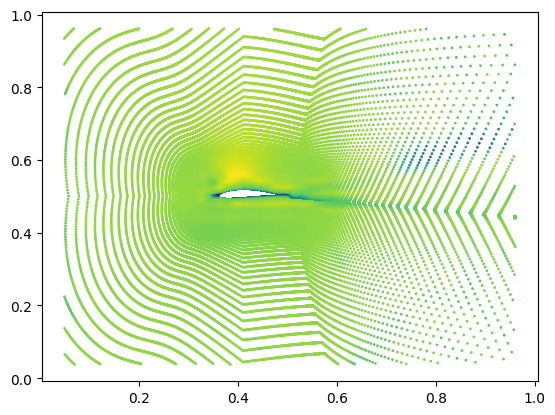

In [221]:
kk= 1
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), encoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

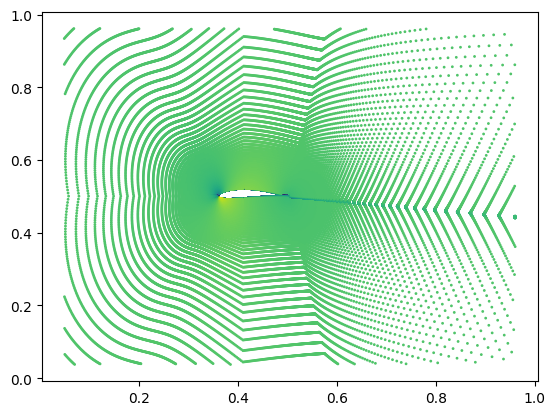

In [222]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=graph.images[graph.batch==kk].cpu().detach(), s=1)

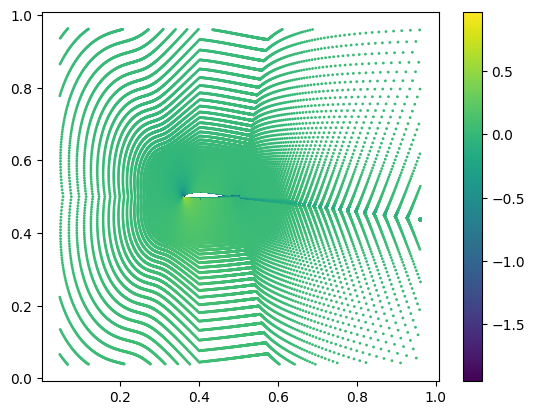

In [ ]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=graph.images[graph.batch==kk].cpu().detach(), s=1)
plt.colorbar()

In [87]:
import itertools

In [88]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [92]:
tinymodel = ModulatedDecoder(2, 1, cfg_dict).cuda()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs //5, gamma=0.5)

In [93]:
for step in range(10000):
    train_loss = 0
    for graph, idx in train_loader:
        n_samples = len(graph)
        
        outputs = outer_step(tinymodel,
                            graph.cuda(),
                            3,
                            0.01,
                            is_train=True,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
        loss = outputs['loss']
        optimizer.zero_grad()
        loss.backward(create_graph=False)
        optimizer.step()
        train_loss = loss.item()*n_samples
    if step%100==0:
        print('train_loss', step, train_loss / ntrain)
    

train_loss 0 0.9893671274185181
train_loss 100 0.8766882419586182
train_loss 200 0.7702465057373047
train_loss 300 0.5948439240455627
train_loss 400 0.6724250316619873
train_loss 500 0.8618783354759216
train_loss 600 0.856521725654602
train_loss 700 0.8457151651382446
train_loss 800 0.8217092156410217
train_loss 900 0.7761620283126831
train_loss 1000 0.7684911489486694
train_loss 1100 0.7923487424850464
train_loss 1200 0.6840311884880066
train_loss 1300 0.7064141035079956
train_loss 1400 0.7229322195053101
train_loss 1500 0.7337769269943237
train_loss 1600 0.7011265158653259
train_loss 1700 0.6961069107055664
train_loss 1800 0.680601954460144
train_loss 1900 0.6667883396148682
train_loss 2000 0.6474536657333374
train_loss 2100 0.6049498319625854
train_loss 2200 0.6409245729446411
train_loss 2300 0.6203242540359497
train_loss 2400 0.6155853867530823
train_loss 2500 0.6241388320922852
train_loss 2600 0.6058942675590515
train_loss 2700 0.6542993783950806
train_loss 2800 0.5738220810890198

In [94]:
outputs = outer_step(tinymodel,
                            graph.cuda(),
                            3,
                            0.01,
                            is_train=False,
                            return_reconstructions=False,
                            gradient_checkpointing=False,
                            loss_type='mse',
                            use_rel_loss=False)
print('outputs', outputs['loss'])

outputs tensor(0.4391, device='cuda:0')


In [95]:
decoding_list = outputs['decoding']

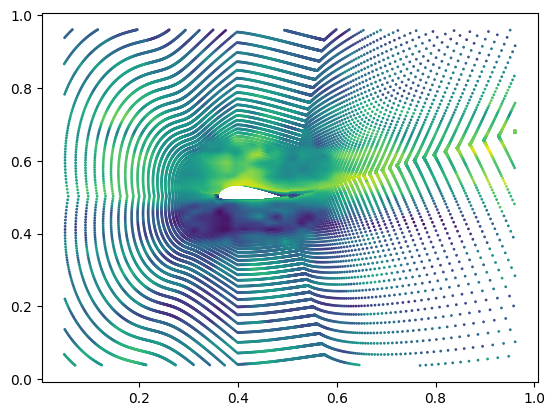

In [96]:
kk= 0
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), decoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

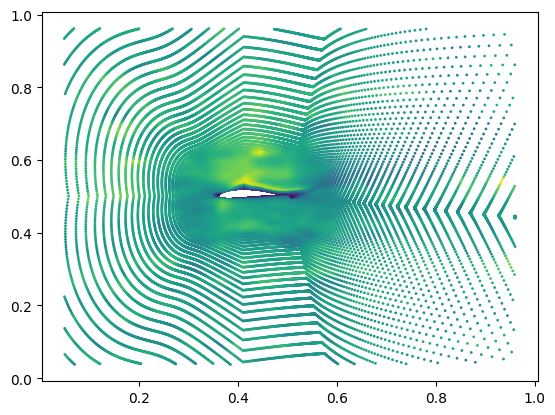

In [97]:
kk= 1
coordinates = graph.pos[graph.batch==kk]
pred = tinymodel(graph.pos[graph.batch==kk].cuda(), decoding_list[kk])
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=pred.cpu().detach(), s=1)

# 1. VQ-VAE

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [201]:
encoding_list[0.params = nn.Parameter(torch.zeros_like(encoding_list[0].params))

In [203]:
encoding_list[0].params

Parameter containing:
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0', requires_grad=True)

In [ ]:
def oute

In [281]:
tinymodel(coordinates, encoding1)

tensor([[0.3101],
        [0.3101],
        [0.3098],
        ...,
        [0.3101],
        [0.3101],
        [0.3101]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SliceBackward0>)

In [264]:
encoding1 = tcnn.Encoding(2, cfg_dict["encoding"]).cuda()

In [270]:
encoding2 = tcnn.Encoding(2, cfg_dict["encoding"]).cuda()

In [273]:
encoding1(coordinates[-2:])

tensor([[ 7.7486e-06, -8.1658e-06, -1.8954e-05, -2.5034e-06,  1.5736e-05,
         -3.8862e-05, -2.8551e-05,  4.5300e-05],
        [ 6.9737e-06, -1.0252e-05, -8.5235e-06, -4.9472e-06,  1.9908e-05,
         -2.8193e-05, -2.6703e-05,  3.7313e-05]], device='cuda:0',
       dtype=torch.float16, grad_fn=<SliceBackward0>)

In [274]:
encoding2(coordinates[-2:])

tensor([[ 7.7486e-06, -8.1658e-06, -1.8954e-05, -2.5034e-06,  1.5736e-05,
         -3.8862e-05, -2.8551e-05,  4.5300e-05],
        [ 6.9737e-06, -1.0252e-05, -8.5235e-06, -4.9472e-06,  1.9908e-05,
         -2.8193e-05, -2.6703e-05,  3.7313e-05]], device='cuda:0',
       dtype=torch.float16, grad_fn=<SliceBackward0>)

In [185]:
4*2**4*2

128

In [110]:
128*128

16384

In [210]:
from copy import deepcopy

In [229]:
nef_clone = deepcopy(nef)
optimizer_clone = torch.optim.Adam(nef_clone.parameters(), lr=0.01)
optimizer_clone.load_state_dict(optimizer.state_dict())

In [230]:
for graph2, idx2 in train_loader:
    break

In [231]:
index = 0
mask = graph2.batch == index

In [232]:
gamma = 1
coordinates2 = graph2.pos[mask].cuda()
images2 = graph2.images[mask].cuda()
images_scaled2 = images2/gamma # images/ gamma

In [233]:
for step in range(100):
    mask = torch.randperm(coordinates2.shape[0])[:18000]
    pred = nef_clone(coordinates2[mask])
    loss = ((pred - images_scaled2[mask])**2).mean()
    optimizer_clone.zero_grad()
    loss.backward()
    optimizer_clone.step()
    scheduler.step()
    print(f"loss: {((pred*gamma - images2[mask])**2).mean()}")

loss: 43.31806182861328
loss: 42.1370964050293
loss: 38.867828369140625
loss: 32.53730010986328
loss: 29.447690963745117
loss: 25.307748794555664
loss: 19.41380500793457
loss: 16.879804611206055
loss: 14.727961540222168
loss: 11.80143928527832
loss: 10.029939651489258
loss: 8.404465675354004
loss: 6.449212074279785
loss: 5.262270927429199
loss: 4.476078987121582
loss: 3.465034246444702
loss: 2.7950916290283203
loss: 2.1117043495178223
loss: 1.6695256233215332
loss: 1.3020683526992798
loss: 0.9579570293426514
loss: 0.7886308431625366
loss: 0.6743971109390259
loss: 0.5224051475524902
loss: 0.43427857756614685
loss: 0.3724731504917145
loss: 0.33420005440711975
loss: 0.28612715005874634
loss: 0.2524595856666565
loss: 0.22077713906764984
loss: 0.21238762140274048
loss: 0.19158200919628143
loss: 0.18699055910110474
loss: 0.17989103496074677
loss: 0.17263257503509521
loss: 0.15991994738578796
loss: 0.15543535351753235
loss: 0.15104348957538605
loss: 0.14600788056850433
loss: 0.143523201346397

In [126]:
with open('../config/tinycuda.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)
cfg_dict = OmegaConf.to_container(cfg)

In [127]:
encoding = tcnn.Encoding(2, cfg_dict["encoding"])

In [128]:
encoding.params.shape

torch.Size([1024])

In [129]:
for name, param in encoding.named_parameters():
    print("name", name)
    print('param', param)

name params
param Parameter containing:
tensor([-7.0460e-05, -3.4031e-05,  3.8013e-05,  ..., -4.5397e-05,
         2.6286e-07,  9.4749e-05], device='cuda:0', requires_grad=True)


In [70]:
encoding.__dict__

{'n_input_dims': 2,
 'encoding_config': {'otype': 'HashGrid',
  'n_levels': 4,
  'n_features_per_level': 4,
  'log2_hashmap_size': 15,
  'base_resolution': 16,
  'per_level_scale': 2},
 'precision': <Precision.Fp16: 1>,
 'training': True,
 '_parameters': OrderedDict([('params',
               Parameter containing:
               tensor([-7.0460e-05, -3.4031e-05,  3.8013e-05,  ...,  2.9598e-05,
                       -9.4659e-05,  8.5390e-05], device='cuda:0', requires_grad=True))]),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'native_tcnn_module': <tinycudann_bindings._86_C.Module at 0x7f5a983aa7f0>,
 'dtype': torch.float16,
 'seed': 1337,
 'loss_scale': 128.0,
 'n_outp

In [37]:
dense_grid = shape2coordinates([256, 256]) * 0.5 + 0.4

In [42]:
dense_grid = dense_grid.cuda().flatten(0,1)

In [43]:
pred = nef(dense_grid)

In [44]:
pred = pred.cpu().detach()
dense_grid = dense_grid.cpu().detach()

In [46]:
pred.min()

tensor(-67.3750, dtype=torch.float16)

tensor([True, True, True,  ..., True, True, True])

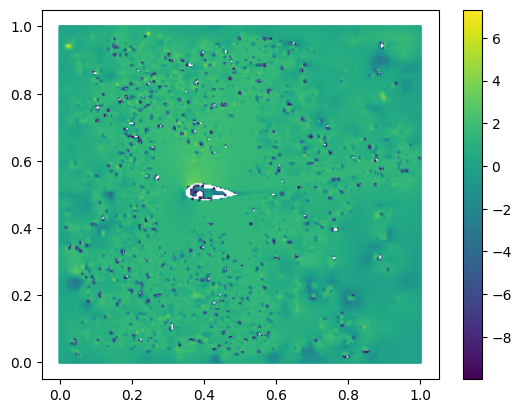

In [52]:
mask = (pred > -1).squeeze()
plt.scatter(dense_grid[mask, 0].detach().cpu(), dense_grid[mask, 1].detach().cpu(), c=gamma*pred[mask].cpu().detach(), s=1)
plt.colorbar()

In [36]:
# with sdf

In [38]:
gamma = 10
coordinates = torch.cat([graph.pos[mask], graph.x[2]], axis=-1)
images = graph.images[mask].cuda()
images_scaled = images/gamma # images/ gamma

TypeError: 'NoneType' object is not subscriptable

In [37]:
w0 = 30
inr = Siren(dim_in=3,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

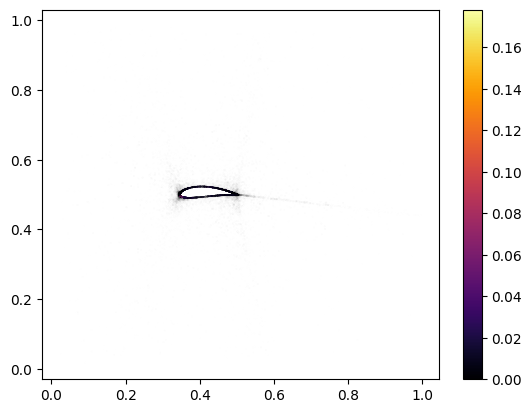

In [30]:
diff = ((gamma*pred - images)**2).cpu().detach()
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), s=diff, c=diff, cmap='inferno')
plt.colorbar()

In [31]:
diff.mean()

tensor(0.0017)

In [32]:
mean_in, mean_out, std_in, std_out = trainset.coef_norm

In [33]:
std_in

array([ 4.1555424e+01,  8.7420683e+00, -2.4084377e+02,  7.6887710e-04],
      dtype=float32)

In [34]:
index_trained = idx[0]

In [35]:
graph_hr = dataset_list[index_trained]

NameError: name 'dataset_list' is not defined

In [183]:
pos_hr = torch.Tensor(graph_hr[..., :2])
pos_hr = (pos_hr - MIN_POS) / (MAX_POS - MIN_POS)

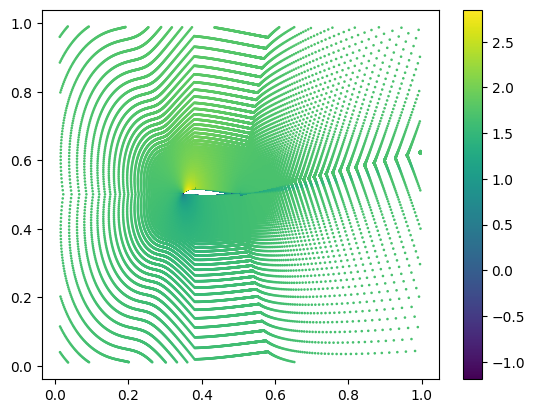

In [184]:
v_hr = (graph_hr[..., key_to_index['vx']] -mean_out[0] )/std_out[0]
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= v_hr)
plt.colorbar()

In [185]:
pred_hr = inr(torch.Tensor(pos_hr).cuda()).cpu().detach()*gamma

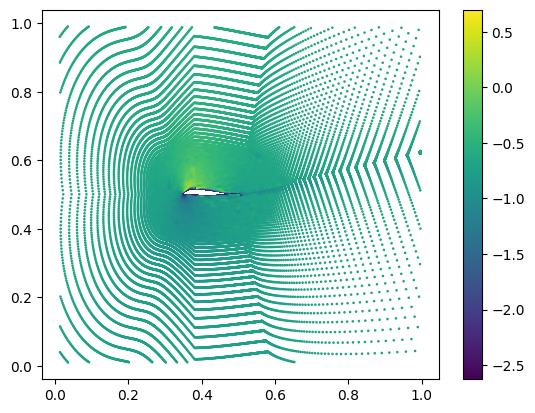

In [186]:
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= pred_hr)
plt.colorbar()

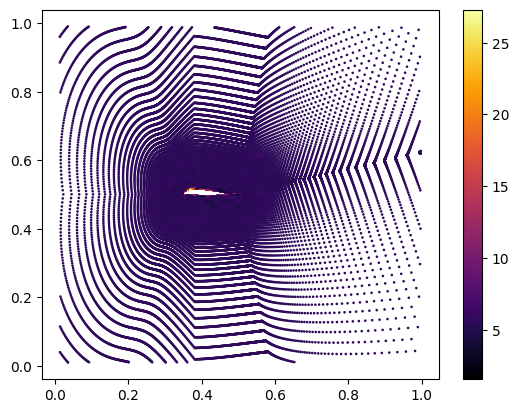

In [188]:
diff = ((pred_hr.detach().cpu().squeeze() - v_hr)**2)
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= diff, cmap="inferno")
plt.colorbar()

# 3. With mesh sampling

In [191]:
trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

In [194]:
#default sample is none
trainset2 = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset2 = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset2.coef_norm)

train_loader2 = DataLoader(trainset2, batch_size=batch_size, shuffle=True)
# test
val_loader2 = DataLoader(valset2, batch_size=batch_size_val, shuffle=True)
device = torch.device("cuda")

100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [04:24<00:00,  2.72it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:30<00:00,  2.66it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [276]:
w0 = 30
inr = Siren(dim_in=2,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

In [277]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [278]:
for graph, idx in train_loader2:
    break

In [279]:
index = 0
mask = graph.batch == index

In [280]:
gamma = 10
coordinates = graph.pos[mask].cuda()
images = graph.images[mask].cuda()
images_scaled = images/gamma # images/ gamma

In [281]:
coords_sub = coordinates[::10]
images_sub = images_scaled[::10]

In [282]:
images_sub.shape

torch.Size([16028, 1])

In [283]:
pred.shape

torch.Size([17950, 1])

In [284]:
epochs=10000
for step in range(epochs):
    pred = inr(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 200 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 1.617484211921692
loss: 0.18210963904857635
loss: 0.23343124985694885
loss: 0.1408294141292572
loss: 0.12923815846443176
loss: 0.17769351601600647
loss: 0.1420958936214447
loss: 0.11587870866060257
loss: 0.10722023993730545
loss: 0.12579309940338135
loss: 0.20803788304328918
loss: 0.1054709255695343
loss: 0.2015542834997177
loss: 0.08223389089107513
loss: 0.08908189833164215
loss: 0.1095796599984169
loss: 0.11075668036937714
loss: 0.09244582802057266
loss: 0.15665967762470245
loss: 0.0776786357164383
loss: 0.09610281139612198
loss: 0.08589402586221695
loss: 0.078227698802948
loss: 0.096023328602314
loss: 0.08573851734399796
loss: 0.08980237692594528
loss: 0.09794095903635025
loss: 0.0983344167470932
loss: 0.12227803468704224
loss: 0.0721668154001236
loss: 0.11731236428022385
loss: 0.09404091536998749
loss: 0.07896041125059128
loss: 0.0675535574555397
loss: 0.07446419447660446
loss: 0.07357921451330185
loss: 0.08298853784799576
loss: 0.10299757122993469
loss: 0.07567496597766876
l

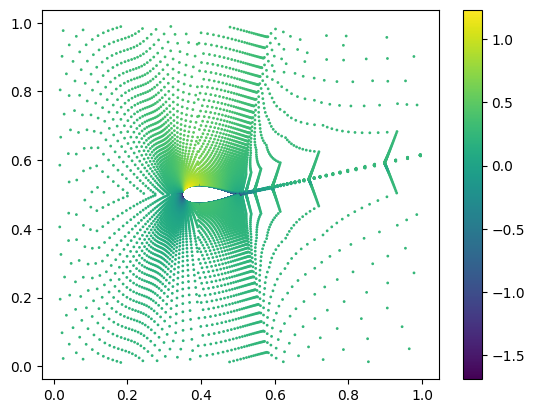

In [273]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*images_sub.detach().cpu(), s=1)
plt.colorbar()

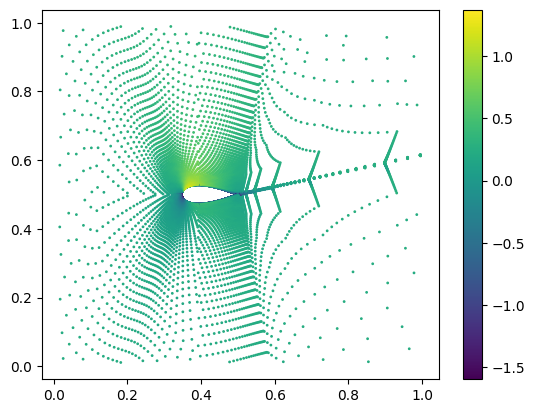

In [274]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

In [321]:
w0 = 30
inr = Siren(dim_in=2,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

In [322]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [323]:
x_mask = (coordinates[..., 0] < 0.6) & (coordinates[..., 0] > 0.4)
y_mask = (coordinates[..., 1] < 0.6) & (coordinates[..., 1] > 0.4)
mask = x_mask & y_mask

In [324]:
coords_sub = (coordinates[mask] - 0.4)*100
images_sub = images_scaled[mask]

In [325]:
epochs=10000
for step in range(epochs):
    pred = inr(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 200 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 1.034475564956665
loss: 0.013061603531241417
loss: 0.007928073406219482
loss: 0.004260915331542492
loss: 0.0032179937697947025
loss: 0.0033631008118391037
loss: 0.0023756169248372316
loss: 0.0017124955775216222
loss: 0.0019903641659766436
loss: 0.002891495358198881
loss: 0.0009753579506650567
loss: 0.0012166238157078624
loss: 0.0012091930257156491
loss: 0.001270992448553443
loss: 0.0014312054263427854
loss: 0.0009011279908008873
loss: 0.0018298239447176456
loss: 0.0017821554793044925
loss: 0.0006422006990760565
loss: 0.0006973950075916946
loss: 0.0013524823589250445
loss: 0.00138726772274822
loss: 0.0014934593345969915
loss: 0.0012435703538358212
loss: 0.0017909595044329762
loss: 0.0014233742840588093
loss: 0.0013678964460268617
loss: 0.0006341334083117545
loss: 0.0009100615861825645
loss: 0.000862468674313277
loss: 0.0013830516254529357
loss: 0.0015914434334263206
loss: 0.0013916543684899807
loss: 0.00035944324918091297
loss: 0.0005034864880144596
loss: 0.0008461619727313519
los

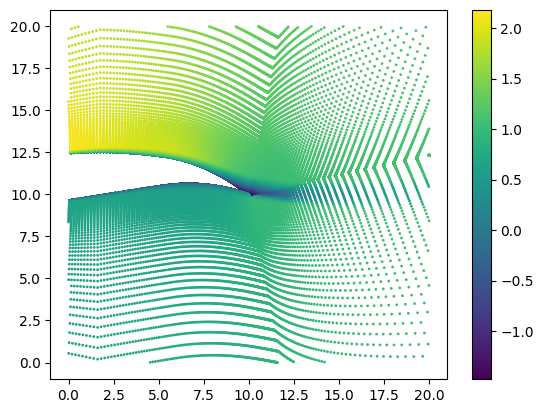

In [326]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*images_sub.detach().cpu(), s=1)
plt.colorbar()

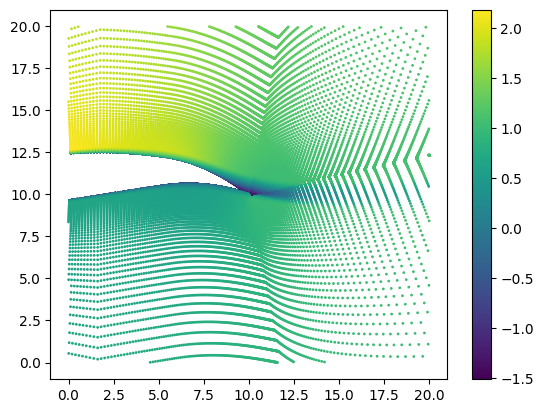

In [327]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

In [ ]:
coord_plt

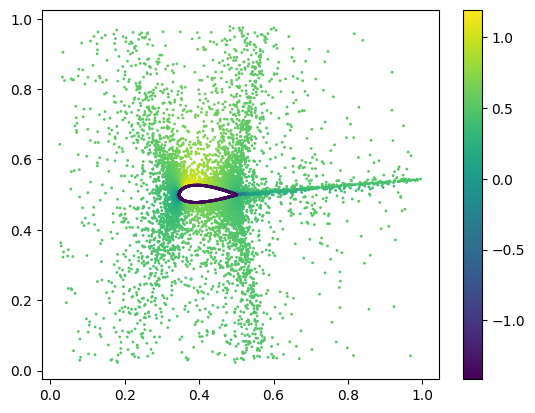

In [128]:
img_plt = images.detach().cpu()
pred_plt = pred.detach().cpu()
coord_plt = coordinates.detach().cpu()
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=img_plt, s=1)
plt.colorbar()

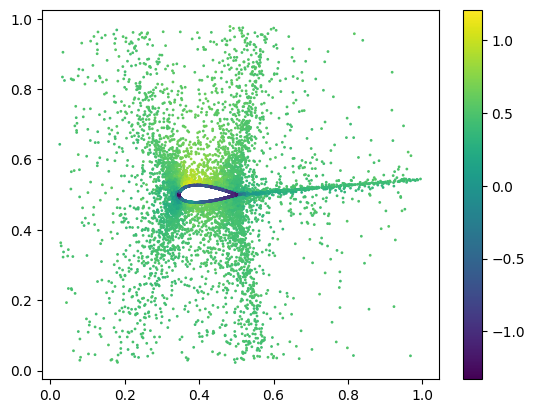

In [129]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=pred_plt*gamma, s=1)
plt.colorbar()

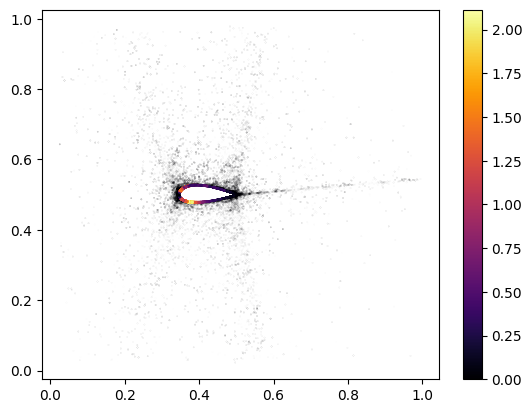

In [130]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=(pred_plt*gamma-img_plt)**2, s=(pred_plt*gamma-img_plt)**2, cmap="inferno")
plt.colorbar()

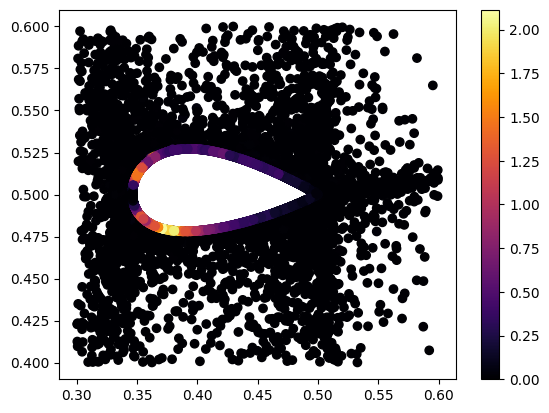

In [134]:
x_mask = (coord_plt[..., 0] < 0.6) & (coord_plt[..., 0] > 0.3)
y_mask = (coord_plt[..., 1] < 0.6) & (coord_plt[..., 1] > 0.4)
plot_mask = x_mask & y_mask
plt.scatter(coord_plt[plot_mask, 0], coord_plt[plot_mask, 1], c=((pred_plt*gamma-img_plt)**2)[plot_mask], cmap="inferno")
plt.colorbar()

In [184]:
from sklearn.cluster import KMeans

In [187]:
clustering_model = KMeans(n_clusters=128, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

In [ ]:
clustering_model.fit(gr